## Скачиваем данные

In [1]:
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-09-22 15:45:39--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  5.96MB/s    in 0.2s    

2024-09-22 15:45:39 (5.96 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
!pip install jaxtyping # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import sys
import einops
import torch
import torch as t
from torch import Tensor
import torch.nn as nn
import numpy as np
import math
from tqdm.notebook import tqdm
from typing import Tuple, List, Optional, Dict, Callable
from jaxtyping import Float, Int
from transformers import AutoTokenizer

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Подготовка данных

У нас есть тексты пьесы Шекспира

In [5]:
with open("input.txt") as fin:
    text = fin.read()

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


Создаем токенайзер, обратите внимание, что у токена there должен быть вначале спецсимвол, обозначающий, что это новое слово, а не часть предыдущего! Используем модель `openai-community/gpt2`

In [6]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2", use_fast=True) # Допишите меня!
assert tokenizer.tokenize("Hello there sometrashtoken") == ['Hello', 'Ġthere', 'Ġsomet', 'r', 'ash', 'token']
assert tokenizer.eos_token == "<|endoftext|>"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


В токенайзере нет спецтокена под паддинг, поэтому выставим PAD_TOKEN = EOS_TOKEN

In [7]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Датасет - 5 баллов

Нам нужен Dataset - что-то, что будет держать данные.
Почитать подробнее можно в [документации](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) или на [примерах](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


Если кратко:
* Dataset должен реализовывать 2 метода: `__getitem__` для получения сэмплов и `__len__` для получения длины датасета
* Нужна функция collate_fn - она будет собирать несколько сэмплов из датасета в один батч
* Нужен DataLoader - объект, который будет брать объекты из датасета и с помощью collate_fn возвращать батчи
* Нужен Sampler - объект, который помогает DataLoader выбирать батчи. В нашем случае это будет просто рандом, но можно собирать сэмплы по одинаковой длине или упорядочить в зависимости от задачи.


Начнем с Dataset. В нем нужно дописать 3 функции, самая важная конструктор `__init__`:
1. Принимает текст
2. Токенизирует его
3. Бьет на непересекающиеся сэмплы размером 200-300 токенов (длину определяем с помощью random.randint)
3. Кладет токены (векторизированные!) в self.texts

In [8]:
import random
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict
from transformers import AutoTokenizer

class MyDataset(Dataset):
    """
    Класс MyDataset представляет датасет, в котором текст токенизируется и разбивается на блоки фиксированного размера.
    """
    def __init__(self, tokenizer: AutoTokenizer, text: str, block_size: int = 512):
        self.tokenizer = tokenizer
        self.texts: List[List[int]] = []
        random.seed(1)

        # Токенизация и разбиение текста на блоки
        tokenized_text = tokenizer.encode(text, add_special_tokens=True)

        # Разделение токенизированного текста на блоки фиксированного размера
        for i in range(0, len(tokenized_text), block_size):
            self.texts.append(tokenized_text[i:i + block_size])

    def __getitem__(self, index: int) -> List[int]:
        return self.texts[index]

    def __len__(self) -> int:
        return len(self.texts)



# Инициализация датасета
dataset = MyDataset(tokenizer, text)

# Декодируем первый образец
sample_0 = dataset.tokenizer.decode(dataset[0])

assert sample_0.startswith(text[:100])

print(sample_0)


Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Collate FN - 5 баллов
Функция сборки, она же collate_fn. Она принимает батч сэмплов, т.е. список объектов, которые нам возвращает датасет!
Она должна принимать `List[List[int]]` батч объектов и возвращать 2 тензора:

* input_ids - `[batch, seq_len]` - батч токенов, в котором добавлены паддинги до максимальной длины в батче.
* mask - `[batch, seq_len]` - батч масок. На позиции `[i, j]` стоит 0, если токен является паддингом, иначе 1.

В качестве значения паддинга для input_ids используйте `tokenizer.pad_token_id`

In [9]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch: List[List[int]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    # Преобразуем списки токенов в тензоры
    input_ids = [torch.tensor(sample, dtype=torch.long) for sample in batch]

    # Паддинг с использованием pad_token_id
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)

    # Создание маски: 1 для реальных токенов, 0 для паддингов
    mask = (input_ids_padded != tokenizer.pad_token_id).long()

    return input_ids_padded, mask


batch = [
    [1, 2, 3, 4],
    [1, 2],
    [1, 2, 3, 4, 5, 6, 7],
]
input_ids_ref = torch.LongTensor([
    [1, 2, 3, 4, 50256, 50256, 50256],
    [1, 2, 50256, 50256, 50256, 50256, 50256],
    [1, 2, 3, 4, 5, 6, 7],
])


mask_ref = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
])

input_ids, mask = collate_fn(batch)

assert (input_ids == input_ids_ref).all()
assert (mask == mask_ref).all()

# Соберем DataLoader - 5 баллов

Нужно заполнить пропущенные поля и убедиться, что в датасете есть замаскированные токены!

In [10]:
from torch.utils.data import DataLoader, RandomSampler

# Инициализация датасета
dataset = MyDataset(tokenizer, text)

# Настраиваем DataLoader
BATCH_SIZE = 16
sampler = RandomSampler(dataset)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    sampler=sampler,
    collate_fn=collate_fn,
)

# Проверим результат
for input_ids, mask in train_loader:
    break
print(mask)

assert (mask.sum(dim=1) < mask.size(1)).sum() < mask.size(0)


tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


In [11]:
input_ids.shape, mask.shape

(torch.Size([16, 512]), torch.Size([16, 512]))

# Transformer

Немного модфицированный блок трансформера, который мы скопируем с предыдущего занятия!

In [12]:
import torch
import torch.nn as nn
from dataclasses import dataclass


@dataclass
class Config:
    d_model: int = 768 # он же hidden_dim - внутрення размерность модели
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257 # он же vocab_size, размер словаря модели
    init_range: float = 0.02
    n_ctx: int = 1024 # число позиционных эмбеддингов
    d_head: int = 64 # размерность головы аттеншена
    d_mlp: int = 3072 # внутренняя размерность FFN-слоя
    n_heads: int = 12 # число голов аттеншена
    n_layers: int = 12 # число слоев трансформера

cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


Эти модули остаются без изменений!
Скопируйте их из предыдущего домашнего задания.

In [ ]:
"""
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_model"]:
        # Скопируйте меня!
        ...

class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_model"]:
        # Скопируйте меня!
        ...


class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Float[Tensor, "batch seq_len d_vocab"]:
        # Скопируйте меня!
        ...

class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(t.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(t.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(t.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        # Скопируйте меня!
        ...

"""

In [13]:
import torch
from torch import Tensor
import torch.nn as nn

class Embed(nn.Module):
    """
    Слой эмбеддингов для преобразования токенов в векторы заданной размерности.

    :param cfg: объект конфигурации, содержащий параметры модели
    """

    def __init__(self, cfg: Config) -> None:
        super().__init__()
        self.cfg = cfg
        # W_E - матрица эмбеддингов размерности (vocab_size, hidden_dim), где
        # vocab_size - размер словаря, hidden_dim - размерность эмбеддинга
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        # Инициализация матрицы эмбеддингов случайными значениями по нормальному распределению
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, input_ids: Tensor) -> Tensor:
        """
        Преобразует входные индексы токенов в эмбеддинги.

        :param input_ids: Тензор целых чисел, представляющий индексы токенов
                          размерности (batch, seq_len).
        :return: Тензор эмбеддингов размерности (batch, seq_len, d_model).
        """
        return self.W_E[input_ids]


class PosEmbed(nn.Module):
    """
    Реализация позиционных эмбеддингов, аналогичная GPT-2, с прединициализированной матрицей W_pos.

    :param cfg: объект конфигурации, содержащий параметры модели.
    """

    def __init__(self, cfg: Config) -> None:
        super().__init__()
        self.cfg = cfg
        # Инициализация матрицы позиционных эмбеддингов W_pos
        self.W_pos = nn.Parameter(torch.empty(cfg.n_ctx, cfg.d_model))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)  # Инициализация весов, как в GPT-2

    def forward(self, input_ids: Tensor) -> Tensor:
        """
        Возвращает прединициализированные позиционные эмбеддинги для заданной последовательности.

        :param input_ids: Тензор целых чисел, представляющий индексы токенов размерности (batch, seq_len).
        :return: Тензор позиционных эмбеддингов размерности (batch, seq_len, d_model).
        """
        batch_size, seq_len = input_ids.shape

        # Извлекаем соответствующие позиционные эмбеддинги из W_pos для текущей длины последовательности
        pos_embeds = self.W_pos[:seq_len, :]  # [seq_len, d_model]

        # Преобразуем позиционные эмбеддинги, чтобы они имели размер (batch, seq_len, d_model)
        pos_embeds = pos_embeds.unsqueeze(0).expand(batch_size, seq_len, self.cfg.d_model)

        return pos_embeds


class Unembed(nn.Module):
    """
    Финальный слой для предсказания следующего токена по контекстуализированным представлениям токенов.

    :param cfg: объект конфигурации, содержащий параметры модели.
    """

    def __init__(self, cfg: Config) -> None:
        super().__init__()
        self.cfg = cfg
        # W_U - матрица размером (d_model, d_vocab), для предсказания токенов
        self.W_U = nn.Parameter(torch.empty((cfg.d_model, cfg.d_vocab)))
        # Инициализация матрицы весов случайными значениями по нормальному распределению
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        # b_U - смещение (bias) для предсказания
        self.b_U = nn.Parameter(torch.zeros((cfg.d_vocab), requires_grad=True))

    def forward(self, x: Tensor) -> Tensor:
        """
        Применяет линейный слой для преобразования эмбеддингов в распределение по словарю.

        :param x: Тензор размерности (batch, seq_len, d_model) - контекстуализированные представления токенов.
        :return: Тензор размерности (batch, seq_len, d_vocab) - распределение по словарю.
        """
        # Применяем линейный слой: умножаем на матрицу W_U и добавляем смещение b_U
        return torch.matmul(x, self.W_U) + self.b_U


class MLP(nn.Module):
    """
    MLP (или FFN) слой с нелинейностью GELU.

    :param cfg: объект конфигурации, содержащий параметры модели.
    """

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        # Инициализация матриц весов и смещений
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))

        # Инициализация весов по нормальному распределению
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(self, x: Tensor) -> Tensor:
        """
        Применение двух линейных преобразований с нелинейностью GELU между ними.

        :param x: Входной тензор размером [batch, seq_len, d_model].
        :return: Выходной тензор размером [batch, seq_len, d_model].
        """
        # Первое линейное преобразование с нелинейностью GELU
        x = torch.matmul(x, self.W_in) + self.b_in
        x = torch.nn.functional.gelu(x, approximate="tanh")

        # Второе линейное преобразование
        x = torch.matmul(x, self.W_out) + self.b_out
        return x


# RMSNorm - 5 баллов
https://arxiv.org/pdf/1910.07467

В статье, на которую вы ссылаетесь, описывается метод нормализации RMSNorm. Давайте реализуем класс `RMSNorm` на основе описания из статьи.

### Формула RMSNorm
Метод нормализации RMSNorm (Root Mean Square Normalization) отличается от LayerNorm тем, что вместо использования среднего значения и дисперсии он нормализует входные данные с использованием среднего квадратичного значения (RMS). Формула для RMSNorm выглядит следующим образом:

$$
y = \frac{x}{\text{RMS}(x)} \odot w
$$

где

$$
\text{RMS}(x) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2}
$$

In [14]:
class RMSNorm(nn.Module):
    def __init__(self, cfg: Config):
        """
        Инициализация RMSNorm слоя.

        Args:
            cfg (Config): Конфигурация модели с параметром d_model, определяющим размерность входных данных.
        """
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model))  # Параметр gamma (веса нормализации)

    def forward(self, x: Float[Tensor, "batch seq_len d_model"]) -> Float[Tensor, "batch seq_len d_model"]:
        """
        Применяет RMS нормализацию к входному тензору x.

        Args:
            x (Float[Tensor, "batch seq_len d_model"]): Входной тензор размерности (batch, seq_len, d_model)

        Returns:
            Float[Tensor, "batch seq_len d_model"]: Нормализованный тензор такой же размерности
        """
        # Рассчитываем RMS для каждого образца
        rms = (x.pow(2).mean(dim=-1, keepdim=True) + 1e-8).sqrt()  # Добавляем epsilon для численной стабильности
        x_norm = x / rms  # Нормализуем входные данные
        return x_norm * self.w  # Применяем гамму (веса)



cfg_rmsnorm = Config(d_model=5)
x = torch.Tensor([[[0.1, 0.2, 0.3, 0.4, 0.5]]])
layer = RMSNorm(cfg_rmsnorm)
y = torch.Tensor([[[0.3015, 0.6030, 0.9045, 1.2060, 1.5076]]])
assert torch.allclose(y, layer(x), atol=1e-4, rtol=1e-3)

# Attention

## Attention Masking - 10 баллов

Опять же копируем имлементацию из предыдущего кода.
Но теперь нужно учесть и маски с паддингами.
Для этого в `apply_causal_mask` подана mask.

В оригинальном задании 3 мы считали, что паддингов нет, поэтому делали маску нижней треугольной, чтобы токен i смотрел на токен j только тогда, когда `i >= j`, т.е. токен i мог смотреть все токены до него.

Теперь же нужно сверх этого добавить еще и паддинг, т.е:

1. Нам дается маска `[batch_size, seq_len]` из `collate_fn`. Напомню, что на позиции `[batch_idx, m]` стоит 1, если токен настоящий или 0, если это паддинг
2. Мы должны модифицировать нашу нижнюю треугольную маску таким образом, чтобы не только не смотреть в будущее, но и не смотреть на паддинг.

In [15]:
import math
import torch
import torch.nn as nn
from torch import Tensor
from dataclasses import dataclass



class Attention(nn.Module):
    IGNORE: Tensor

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        # Инициализация параметров Q, K, V и O
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        # Изменение размерности W_O на [n_heads * d_head, d_model]
        self.W_O = nn.Parameter(torch.empty((cfg.n_heads * cfg.d_head, cfg.d_model)))
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))

        # Инициализация весов
        nn.init.normal_(self.W_Q, std=cfg.init_range)
        nn.init.normal_(self.W_K, std=cfg.init_range)
        nn.init.normal_(self.W_V, std=cfg.init_range)
        nn.init.normal_(self.W_O, std=cfg.init_range)

        # Регистрируем буфер для значения игнорирования (−inf) как скаляр
        self.register_buffer("IGNORE", torch.tensor(float("-inf"), dtype=torch.float32))

    def forward(
        self, x: Tensor, mask: Tensor
    ) -> Tensor:
        """
        Применяет механизм внимания с учётом causal и padding масок.

        Args:
            x (Tensor): Входные эмбеддинги размерности [batch, seq_len, d_model].
            mask (Tensor): Маска паддингов размерности [batch, seq_len], где 1 - реальные токены, 0 - паддинги.

        Returns:
            Tensor: Выходные эмбеддинги размерности [batch, seq_len, d_model].
        """
        batch_size, seq_len, d_model = x.shape
        n_heads = self.cfg.n_heads
        d_head = self.cfg.d_head

        # 1. Вычисляем Q, K, V
        # Используем torch.einsum для проекции, добавляя смещения
        Q = torch.einsum('nhm,bsd->bnsm', self.W_Q, x) + self.b_Q.view(1, n_heads, 1, d_head)
        K = torch.einsum('nhm,bsd->bnsm', self.W_K, x) + self.b_K.view(1, n_heads, 1, d_head)
        V = torch.einsum('nhm,bsd->bnsm', self.W_V, x) + self.b_V.view(1, n_heads, 1, d_head)

        # 2. Вычисляем скалярные произведения Q и K^T с использованием torch.matmul
        K_transposed = K.transpose(-2, -1)  # [batch, n_heads, d_head, seq_len]
        attn_scores = torch.matmul(Q, K_transposed) / math.sqrt(d_head)  # [batch, n_heads, seq_len, seq_len]

        # 3. Применяем маски
        attn_scores = self.apply_causal_mask(attn_scores, mask)  # [batch, n_heads, seq_len, seq_len]

        # 4. Применяем softmax
        attn_weights = torch.softmax(attn_scores, dim=-1)  # [batch, n_heads, seq_len, seq_len]

        # 5. Взвешенное суммирование V
        # Используем torch.matmul вместо torch.einsum для избежания конфликтов индексов
        z = torch.matmul(attn_weights, V)  # [batch, n_heads, seq_len, d_head]

        # 6. Финальная проекция
        # Переставляем оси и объединяем n_heads и d_head
        z = z.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, n_heads * d_head)  # [batch, seq_len, n_heads*d_head]
        # Проецируем обратно в d_model пространство
        output = torch.matmul(z, self.W_O) + self.b_O  # [batch, seq_len, d_model]

        return output

    def apply_causal_mask(
        self, attn_scores: Tensor, mask: Tensor
    ) -> Tensor:
        """
        Применяет causal и padding маски к скалярным произведениям внимания.

        Args:
            attn_scores (Tensor): Скалярные произведения Q и K^T размерности [batch, n_heads, seq_len, seq_len].
            mask (Tensor): Маска паддингов размерности [batch, seq_len].

        Returns:
            Tensor: Замаскированные скалярные произведения.
        """
        batch_size, n_heads, seq_len, _ = attn_scores.shape

        # Создаём causal маску: нижняя треугольная матрица
        causal_mask = torch.tril(torch.ones((seq_len, seq_len), device=attn_scores.device)).unsqueeze(0).unsqueeze(0)  # [1,1,7,7]

        # Создаём padding маску: [batch, 1, 1, seq_len]
        padding_mask = mask.unsqueeze(1).unsqueeze(2)  # [batch,1,1,7]

        # Комбинируем обе маски: логическое И
        combined_mask = causal_mask * padding_mask  # [batch,1,7,7]

        # Расширяем маску на количество голов внимания
        combined_mask = combined_mask.expand(-1, n_heads, -1, -1)  # [batch, n_heads,7,7]

        # Применяем маску: устанавливаем attn_scores в -inf там, где mask == 0
        attn_scores = attn_scores.masked_fill(combined_mask == 0, self.IGNORE)  # [batch, n_heads,7,7]

        return attn_scores



# Создание отдельной конфигурации для теста
test_cfg = Config(
    d_model=32,    # Уменьшено для теста
    n_heads=4,     # Уменьшено для теста
    d_head=8,      # Уменьшено для теста
    n_ctx=7        # Соответствует seq_len=7 для теста
)

# Создание экземпляра Attention с тестовой конфигурацией
attn = Attention(test_cfg).to(device)

# Создание тестовых данных
mask_padding = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
]).to(device)

lengths = mask_padding.sum(dim=1).tolist()

batch_size = 3
seq_len = 7
n_heads = test_cfg.n_heads  # 4
d_head = test_cfg.d_head    # 8

# Создание случайного тензора внимания для проверки apply_causal_mask
x = torch.rand(batch_size, n_heads, seq_len, seq_len).to(device)

# Применение маски
softmax_res = torch.softmax(attn.apply_causal_mask(x, mask_padding), dim=-1)

# Проверка масок
for batch_idx in range(batch_size):
    for head_idx in range(n_heads):
        sm = softmax_res[batch_idx, head_idx]
        l = lengths[batch_idx]
        for i in range(seq_len):
            for j in range(seq_len):
                # i < j - Causal mask, проверяем, что не смотрим в будущее!
                # j >= l - проверяем, что не смотрим на паддинги!
                if i < j or j >= l:
                    assert sm[i, j] == 0, (batch_idx, head_idx, i, j, sm[i, j])

print("Тест маскировки пройден успешно!")

# Дополнительно: Проверка полного прохождения forward
output = attn(torch.rand(batch_size, seq_len, test_cfg.d_model).to(device), mask_padding)

print("Forward метод работает корректно.")

del output, attn
torch.cuda.empty_cache()

Тест маскировки пройден успешно!
Forward метод работает корректно.


## Rotary Embeddings - 5 баллов

Нужно написать роторные эмбеддинги из [статьи](https://arxiv.org/pdf/2104.09864). В качестве формулы нужно взять пункт 3.4.2!

Их можно использовать в attention, но это не обязательно, здесь баллы даются только за имплементацию самих роторных эмбеддингов.

In [16]:
import torch
import torch.nn as nn
import math

# Реализация роторных позиционных эмбеддингов (RoPE)
def rotate_every_two(x):
    """
    Вращает каждые два элемента в последнем измерении тензора.

    Args:
        x (Tensor): Тензор с последним измерением кратным 2.

    Returns:
        Tensor: Вращённый тензор.
    """
    x1 = x[..., 0::2]
    x2 = x[..., 1::2]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, theta=10_000):
    """
    Применяет роторные позиционные эмбеддинги к запросам и ключам.

    Args:
        q (Tensor): Запросы размерности [batch_size, n_heads, seq_len, d_head].
        k (Tensor): Ключи размерности [batch_size, n_heads, seq_len, d_head].
        theta (float, optional): Масштабный фактор для вычисления углов. По умолчанию 10_000.

    Returns:
        Tuple[Tensor, Tensor]: Вращённые запросы и ключи.
    """
    batch_size, n_heads, seq_len, d_head = q.size()
    assert d_head % 2 == 0, "d_head должно быть чётным для роторных эмбеддингов."

    device = q.device
    dim = torch.arange(d_head // 2, device=device)

    angles = torch.arange(seq_len, device=device).unsqueeze(1) / (theta ** (2 * dim / d_head))  # [seq_len, d_head//2]
    sin = torch.sin(angles)  # [seq_len, d_head//2]
    cos = torch.cos(angles)  # [seq_len, d_head//2]

    sin = sin.unsqueeze(0).unsqueeze(0).unsqueeze(-1)  # [1, 1, seq_len, d_head//2, 1]
    cos = cos.unsqueeze(0).unsqueeze(0).unsqueeze(-1)  # [1, 1, seq_len, d_head//2, 1]

    q = q.view(batch_size, n_heads, seq_len, d_head // 2, 2)
    k = k.view(batch_size, n_heads, seq_len, d_head // 2, 2)

    q_rot = q * cos - rotate_every_two(q) * sin  # [batch_size, n_heads, seq_len, d_head//2, 2]
    k_rot = k * cos - rotate_every_two(k) * sin  # [batch_size, n_heads, seq_len, d_head//2, 2]

    q_rot = q_rot.view(batch_size, n_heads, seq_len, d_head)
    k_rot = k_rot.view(batch_size, n_heads, seq_len, d_head)

    return q_rot, k_rot


### Attention c apply_rotary_pos_emb

In [17]:
import math



# Реализация Attention
class Attention(nn.Module):
    IGNORE: Tensor

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        # Инициализация параметров Q, K, V и O
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        # Изменение размерности W_O на [n_heads * d_head, d_model]
        self.W_O = nn.Parameter(torch.empty((cfg.n_heads * cfg.d_head, cfg.d_model)))
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))

        # Инициализация весов
        nn.init.normal_(self.W_Q, std=cfg.init_range)
        nn.init.normal_(self.W_K, std=cfg.init_range)
        nn.init.normal_(self.W_V, std=cfg.init_range)
        nn.init.normal_(self.W_O, std=cfg.init_range)

        # Регистрируем буфер для значения игнорирования (−inf) как скаляр
        self.register_buffer("IGNORE", torch.tensor(float("-inf"), dtype=torch.float32))

    def forward(
        self,
        x: Tensor,                          # [batch, seq_len, d_model]
        mask: Tensor                        # [batch, seq_len]
    ) -> Tensor:                           # Возвращает [batch, seq_len, d_model]
        """
        Применяет механизм внимания с учётом causal и padding масок и роторных эмбеддингов.

        Args:
            x (Tensor): Входные эмбеддинги размерности [batch, seq_len, d_model].
            mask (Tensor): Маска паддингов размерности [batch, seq_len], где 1 - реальные токены, 0 - паддинги.

        Returns:
            Tensor: Выходные эмбеддинги размерности [batch, seq_len, d_model].
        """
        batch_size, seq_len, d_model = x.shape
        n_heads = self.cfg.n_heads
        d_head = self.cfg.d_head

        # 1. Вычисляем Q, K, V
        Q = torch.einsum('nhm,bsd->bnsm', self.W_Q, x) + self.b_Q.view(1, n_heads, 1, d_head)
        K = torch.einsum('nhm,bsd->bnsm', self.W_K, x) + self.b_K.view(1, n_heads, 1, d_head)
        V = torch.einsum('nhm,bsd->bnsm', self.W_V, x) + self.b_V.view(1, n_heads, 1, d_head)

        # 2. Применяем роторные позиционные эмбеддинги
        Q, K = apply_rotary_pos_emb(Q, K, theta=10_000)

        # 3. Вычисляем скалярные произведения Q и K^T
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_head)  # [batch, n_heads, seq_len, seq_len]

        # 4. Применяем маски
        attn_scores = self.apply_causal_mask(attn_scores, mask)  # [batch, n_heads, seq_len, seq_len]

        # 5. Применяем softmax
        attn_weights = torch.softmax(attn_scores, dim=-1)  # [batch, n_heads, seq_len, seq_len]

        # 6. Взвешенное суммирование V
        z = torch.matmul(attn_weights, V)  # [batch, n_heads, seq_len, d_head]

        # 7. Финальная проекция
        z = z.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, n_heads * d_head)  # [batch, seq_len, n_heads*d_head]
        output = torch.matmul(z, self.W_O) + self.b_O  # [batch, seq_len, d_model]

        return output

    def apply_causal_mask(
        self,
        attn_scores: Tensor,
        mask: Tensor
    ) -> Tensor:
        """
        Применяет causal и padding маски к скалярным произведениям внимания.

        Args:
            attn_scores (Tensor): Скалярные произведения Q и K^T размерности [batch, n_heads, seq_len, seq_len].
            mask (Tensor): Маска паддингов размерности [batch, seq_len].

        Returns:
            Tensor: Замаскированные скалярные произведения.
        """
        batch_size, n_heads, seq_len, _ = attn_scores.shape

        # Создаём causal маску: нижняя треугольная матрица
        causal_mask = torch.tril(torch.ones((seq_len, seq_len), device=attn_scores.device)).unsqueeze(0).unsqueeze(0)  # [1,1,seq_len,seq_len]

        # Создаём padding маску: [batch, 1, 1, seq_len]
        padding_mask = mask.unsqueeze(1).unsqueeze(2)  # [batch,1,1,seq_len]

        # Комбинируем обе маски: логическое И
        combined_mask = causal_mask * padding_mask  # [batch,1,seq_len,seq_len]

        # Расширяем маску на количество голов внимания
        combined_mask = combined_mask.expand(-1, n_heads, -1, -1)  # [batch, n_heads, seq_len, seq_len]

        # Применяем маску: устанавливаем attn_scores в -inf там, где mask == 0
        attn_scores = attn_scores.masked_fill(combined_mask == 0, self.IGNORE)  # [batch, n_heads, seq_len, seq_len]

        return attn_scores


# Создание отдельной конфигурации для теста
train_config = Config(
    d_model=128,
    n_ctx=512,
    n_heads=8,
    d_head=16,
    d_mlp=512,
    n_layers=12
)
# Создание экземпляра Attention с тестовой конфигурацией
attn = Attention(test_cfg).to(device)

# Создание тестовых данных
mask_padding = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
]).to(device)

lengths = mask_padding.sum(dim=1).tolist()

batch_size = 3
seq_len = 7
n_heads = test_cfg.n_heads  # 4
d_head = test_cfg.d_head    # 8

# Создание случайного тензора внимания для проверки apply_causal_mask
x = torch.rand(batch_size, n_heads, seq_len, seq_len).to(device)

# Применение маски
softmax_res = torch.softmax(attn.apply_causal_mask(x, mask_padding), dim=-1)

# Проверка масок
for batch_idx in range(batch_size):
    for head_idx in range(n_heads):
        sm = softmax_res[batch_idx, head_idx]
        l = lengths[batch_idx]
        for i in range(seq_len):
            for j in range(seq_len):
                # i < j - Causal mask, проверяем, что не смотрим в будущее!
                # j >= l - проверяем, что не смотрим на паддинги!
                if i < j or j >= l:
                    assert sm[i, j] == 0, (batch_idx, head_idx, i, j, sm[i, j])

print("Тест маскировки пройден успешно!")

# Дополнительно: Проверка полного прохождения forward
output = attn(torch.rand(batch_size, seq_len, test_cfg.d_model).to(device), mask_padding)
print("Forward метод работает корректно.")

del output, attn
torch.cuda.empty_cache()

Тест маскировки пройден успешно!
Forward метод работает корректно.


# Собираем Transformer - 5 баллов

1. В TransformerBlock и DemoTransformer немного модифицируем код из предыдущего задания, чтобы передавать mask в слои аттеншена.
2. В зависимости от того, хотим ли мы использовать RoPE или не хотим меняется также то, используем ли мы Positional Embeddings или нет!

В задании не будут сниматься баллы, если используются абсолютные позиционные эмбеддинги.


In [ ]:

"""
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = RMSNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = RMSNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"], mask: Float[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        attn = self.attn(self.ln1(x), mask)
        ...
        # Ваш код здесь!

class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = RMSNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"], mask: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_vocab"]:
        ...
        # Ваш код здесь!

"""

In [18]:
# Реализация TransformerBlock
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = RMSNorm(cfg)       # Первый слой нормализации
        self.attn = Attention(cfg)    # Механизм внимания с RoPE
        self.ln2 = RMSNorm(cfg)       # Второй слой нормализации
        self.mlp = MLP(cfg)           # Feed-Forward сеть

    def forward(
        self,
        x: Tensor,                          # [batch, seq_len, d_model]
        mask: Tensor                        # [batch, seq_len]
    ) -> Tensor:                           # Возвращает [batch, seq_len, d_model]
        """
        Применяет один Transformer блок к входному тензору.

        Args:
            x (Tensor): Входные эмбеддинги размерности [batch, seq_len, d_model].
            mask (Tensor): Маска паддингов размерности [batch, seq_len], где 1 - реальные токены, 0 - паддинги.

        Returns:
            Tensor: Выходные эмбеддинги размерности [batch, seq_len, d_model].
        """
        # Применяем нормализацию перед механизмом внимания
        norm_x1 = self.ln1(x)                        # [batch, seq_len, d_model]

        # Механизм внимания с остаточной связью
        attn_out = self.attn(norm_x1, mask)          # [batch, seq_len, d_model]
        x = x + attn_out                             # Остаточная связь

        # Применяем нормализацию перед MLP
        norm_x2 = self.ln2(x)                        # [batch, seq_len, d_model]

        # Feed-Forward сеть с остаточной связью
        mlp_out = self.mlp(norm_x2)                  # [batch, seq_len, d_model]
        x = x + mlp_out                              # Остаточная связь

        return x

# Реализация DemoTransformer
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)                        # Эмбеддинги токенов
        self.pos_embed = PosEmbed(cfg)                  # Позиционные эмбеддинги
        self.blocks = nn.ModuleList([
            TransformerBlock(cfg) for _ in range(cfg.n_layers)
        ])                                            # Список Transformer блоков
        self.ln_final = RMSNorm(cfg)                    # Финальная нормализация
        self.unembed = Unembed(cfg)                     # Линейный слой для предсказания токенов

    def forward(self, input_ids: Tensor, mask: Tensor) -> Tensor:
        """
        Выполняет форвард-проход через Transformer модель.

        Args:
            input_ids (Tensor): Входные идентификаторы токенов размерности [batch, seq_len].
            mask (Tensor): Маска паддингов размерности [batch, seq_len], где 1 - реальные токены, 0 - паддинги.

        Returns:
            Tensor: Логиты размерности [batch, seq_len, d_vocab].
        """
        # Получаем эмбеддинги токенов
        x = self.embed(input_ids)                      # [batch, seq_len, d_model]

        # Получаем позиционные эмбеддинги и добавляем их
        pos_embeds = self.pos_embed(input_ids)          # [batch, seq_len, d_model]
        x = x + pos_embeds                              # [batch, seq_len, d_model]

        # Пропускаем через все Transformer блоки
        for block in self.blocks:
            x = block(x, mask)                           # [batch, seq_len, d_model]

        # Применяем финальную нормализацию
        x = self.ln_final(x)                            # [batch, seq_len, d_model]

        # Преобразуем скрытые состояния обратно в логиты словаря
        logits = self.unembed(x)                        # [batch, seq_len, d_vocab]

        return logits

# Финальные проверки

In [35]:
# Создание экземпляра модели
train_config = Config(
    d_model=128,
    n_ctx=512,    # Максимальная длина последовательности
    n_heads=8,
    d_head=16,
    d_mlp=512,
    n_layers=12,
    d_vocab=50257
)
model = DemoTransformer(train_config).to(device)

In [36]:
for input_ids, mask in train_loader:
    break

with torch.no_grad():
    p = model(input_ids.to(device), mask.to(device))

assert list(p.shape) == [input_ids.size(0), input_ids.size(1), train_config.d_vocab]
del model
torch.cuda.empty_cache()

# Обучение - 5 баллов

Здесь нужно написать обычный training loop! Но он не так уж и прост. Давайте по шагам разберемся, как нам быть:
1. Берем input_ids, mask, прогоняем через модель, получаем тензор p `[batch_size, seq_len, vocab_size]`
2. В качестве меток мы берем те же input_ids! Только их нужно сдвинуть на 1 вправо, т.к. i-й токен предсказывает (i + 1)-й
3. В качестве предиктов берем input_ids! Только начало нужно тоже обрезать, т.к. у нас нет токенов, которые занимались бы предсказанием 0-го токена в последоватсельности!
4. Паддингам ставим метки -100, это значение ignore_loss, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) его игнорирует при подсчете лососв!
5. Превращаем p в тензор `[batch_size * (seq_len - 1), vocab_size]`, вектор правильных меток labels (из input_ids) превращаем в `[batch_size * (seq_len - 1)]`, считаем функцию потерь!
6. Не забываем все стандартные вещи в training loop: обнуление градиентов, backward, шаг оптимизации.


In [37]:
# Создание экземпляра модели
train_config = Config(
    d_model=128,
    n_ctx=256,    # Максимальная длина последовательности иначе не лезет
    n_heads=8,
    d_head=16,
    d_mlp=512,
    n_layers=12,
    d_vocab=50257
)
model = DemoTransformer(train_config).to(device)

# обновим текст
with open("input.txt") as fin:
    text = fin.read()

# Инициализация датасета
dataset = MyDataset(tokenizer, text, train_config.n_ctx)

# Настраиваем DataLoader
BATCH_SIZE = 16
sampler = RandomSampler(dataset)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    sampler=sampler,
    collate_fn=collate_fn,
)

## Определение Функции Лямбда для LambdaLR
Функция будет рассчитывать коэффициент умножения на основе текущего шага и общего количества шагов обучения. Для этого:

- Определим общее количество шагов обучения (total_steps).
- Вычислим количество шагов для разогрева (warmup_steps), равное 10% от total_steps.
- В зависимости от текущего шага, будем возвращать коэффициент умножения:
- Если текущий шаг меньше warmup_steps: линейно увеличиваем от 0 до 1.
Иначе: линейно уменьшаем от 1 до 0.

In [38]:
from torch.optim.lr_scheduler import LambdaLR


def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """
    Возвращает планировщик lr, который линейно увеличивает lr от 0 до начального значения за num_warmup_steps,
    а затем линейно уменьшает от начального значения до 0 за num_training_steps - num_warmup_steps.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda)



## Цикл обучения

In [42]:
from torch import amp
import torch.optim as optim
# Определение оптимизатора и функции потерь
initial_lr = 1e-4  # или 1e-5
# Добавление регуляризации, такой как weight_decay, может помочь стабилизировать
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Параметры обучения
num_epochs = 100
batch_size = 16

# Определение количества шагов и warmup_steps
accumulation_steps = 4  # Количество шагов накопления
num_training_steps = num_epochs * len(train_loader) // accumulation_steps
warmup_steps = int(0.1 * num_training_steps)  # 10% шагов для разогрева

# Инициализация планировщика lr
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, num_training_steps)


# Инициализация GradScaler для смешанной точности
scaler = amp.GradScaler()

# Инициализация списка для хранения lr
lr_values = []
loss_values = []

# Тренировочный цикл
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    # Включаем режим обучения
    model.train()

    for step, (batch_input_ids, batch_mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        batch_input_ids = batch_input_ids.to(device)
        batch_mask = batch_mask.to(device)

        #optimizer.zero_grad()

        with amp.autocast(device_type='cuda'):
            outputs = model(batch_input_ids, batch_mask)  # [batch, seq_len, d_vocab]

            # Проверка на NaN в выходных данных модели
            if torch.isnan(outputs).any():
                print(f"NaN обнаружены в выходных данных модели на эпохе {epoch+1}. Прерывание обучения.")
                break

            preds = outputs[:, :-1, :].contiguous()       # [batch, seq_len -1, d_vocab]
            labels = batch_input_ids[:, 1:].contiguous() # [batch, seq_len -1]
            labels = labels.clone()
            labels[batch_mask[:, 1:] == 0] = -100        # Маскирование паддинговых токенов
            preds = preds.view(-1, train_config.d_vocab) # [batch * (seq_len -1), d_vocab]
            labels = labels.view(-1)                     # [batch * (seq_len -1)]
            loss = criterion(preds, labels)
            loss = loss / accumulation_steps  # Если используем градиентное накопление,
                                              # делим loss на количество шагов накопления
            # Проверка на NaN в loss
            if torch.isnan(loss):
                print(f"NaN обнаружены в loss на эпохе {epoch+1}. Прерывание обучения.")
                num_batches += 1
                break

        scaler.scale(loss).backward()

        # Градиентный клиппинг
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Обновление параметров и планировщика только на последнем шаге накопления
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Обновление lr после шага оптимизации
            optimizer.zero_grad()


        # Сохранение текущего lr
        current_lr = optimizer.param_groups[0]['lr']
        lr_values.append(current_lr)
        loss_values.append(loss.item() * accumulation_steps)  # Умножаем обратно для правильного отображения
        epoch_loss += loss.item() * accumulation_steps  # Умножаем обратно для правильного отображения
        num_batches += 1

        # Проверка градиентов на NaN
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN градиентов обнаружены в параметре: {name}. Прерывание обучения.")
                    break

    # Проверка, была ли прервана эпоха из-за NaN
    if torch.isnan(torch.tensor(epoch_loss / (num_batches))):
        print(f"Обнаружены NaN в loss на эпохе {epoch+1}. Прерывание обучения.")
        break

    avg_epoch_loss = epoch_loss / num_batches
    loss_values.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")


    # Очистка кеша памяти GPU
    torch.cuda.empty_cache()

Epoch 1/100:   0%|          | 0/83 [00:00<?, ?it/s]

RuntimeError: unscale_() has already been called on this optimizer since the last update().

In [43]:
from torch import amp
import torch.optim as optim
# Определение оптимизатора и функции потерь
initial_lr = 1e-4  # или 1e-5
# Добавление регуляризации, такой как weight_decay, может помочь стабилизировать
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Параметры обучения
num_epochs = 100
batch_size = 16

# Определение количества шагов и warmup_steps
accumulation_steps = 4  # Количество шагов накопления
num_training_steps = num_epochs * len(train_loader) // accumulation_steps
warmup_steps = int(0.1 * num_training_steps)  # 10% шагов для разогрева

# Инициализация планировщика lr
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, num_training_steps)


# Инициализация GradScaler для смешанной точности
scaler = amp.GradScaler()

# Инициализация списка для хранения lr
lr_values = []
loss_values = []



# Тренировочный цикл с градиентным накоплением
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    # Включаем режим обучения
    model.train()

    for step, (batch_input_ids, batch_mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        batch_input_ids = batch_input_ids.to(device)
        batch_mask = batch_mask.to(device)

        with amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(batch_input_ids, batch_mask)  # [batch, seq_len, d_vocab]
            preds = outputs[:, :-1, :].contiguous()       # [batch, seq_len -1, d_vocab]
            labels = batch_input_ids[:, 1:].contiguous() # [batch, seq_len -1]
            labels = labels.clone()
            labels[batch_mask[:, 1:] == 0] = -100        # Маскирование паддинговых токенов
            preds = preds.view(-1, train_config.d_vocab) # [batch * (seq_len -1), d_vocab]
            labels = labels.view(-1)                     # [batch * (seq_len -1)]
            loss = criterion(preds, labels)
            loss = loss / accumulation_steps          # Нормализация потерь

        scaler.scale(loss).backward()

        # Градиентный клиппинг
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Обновление параметров и планировщика только на последнем шаге накопления
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Обновление lr после шага оптимизации
            optimizer.zero_grad()

        # Сохранение текущего lr и loss
        current_lr = optimizer.param_groups[0]['lr']
        lr_values.append(current_lr)
        loss_values.append(loss.item() * accumulation_steps)  # Умножаем обратно на accumulation_steps для правильного отображения

        epoch_loss += loss.item() * accumulation_steps  # Умножаем обратно на accumulation_steps для правильного отображения
        num_batches += 1

        # Проверка градиентов на NaN
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN градиентов обнаружены в параметре: {name} на эпохе {epoch+1}, батче {num_batches}. Прерывание обучения.")
                    break

    # Проверка, была ли прервана эпоха из-за NaN
    if torch.isnan(epoch_loss / num_batches):
        print(f"Обнаружены NaN в loss на эпохе {epoch+1}. Прерывание обучения.")
        break

    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Очистка кеша памяти GPU (опционально)
    torch.cuda.empty_cache()

# Визуализация графиков loss и learning rate
plt.figure(figsize=(14, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# График learning rate
plt.subplot(1, 2, 2)
plt.plot(lr_values, label='Learning Rate', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 1/100:   0%|          | 0/83 [00:00<?, ?it/s]

RuntimeError: unscale_() has already been called on this optimizer since the last update().

In [44]:
from torch import amp
import torch.optim as optim
# Определение оптимизатора и функции потерь
initial_lr = 1e-4  # или 1e-5
# Добавление регуляризации, такой как weight_decay, может помочь стабилизировать
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Параметры обучения
num_epochs = 100
batch_size = 16

# Определение количества шагов и warmup_steps
num_training_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * num_training_steps)  # 10% от общего количества шагов

# Инициализация планировщика lr
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, num_training_steps)


# Инициализация GradScaler для смешанной точности
scaler = amp.GradScaler()

# Инициализация списка для хранения lr
lr_values = []
loss_values = []

# Тренировочный цикл
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_input_ids, batch_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_input_ids = batch_input_ids.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        with amp.autocast(device_type='cuda'):
            outputs = model(batch_input_ids, batch_mask)  # [batch, seq_len, d_vocab]

            # Проверка на NaN в выходных данных модели
            if torch.isnan(outputs).any():
                print(f"NaN обнаружены в выходных данных модели на эпохе {epoch+1}. Прерывание обучения.")
                break

            preds = outputs[:, :-1, :].contiguous()       # [batch, seq_len -1, d_vocab]
            labels = batch_input_ids[:, 1:].contiguous() # [batch, seq_len -1]
            labels = labels.clone()
            labels[batch_mask[:, 1:] == 0] = -100        # Маскирование паддинговых токенов
            preds = preds.view(-1, train_config.d_vocab) # [batch * (seq_len -1), d_vocab]
            labels = labels.view(-1)                     # [batch * (seq_len -1)]
            loss = criterion(preds, labels)

            # Проверка на NaN в loss
            if torch.isnan(loss):
                print(f"NaN обнаружены в loss на эпохе {epoch+1}. Прерывание обучения.")
                num_batches += 1
                break

            loss = loss / 1  # Если используем градиентное накопление,
                             # делим loss на количество шагов накопления

        scaler.scale(loss).backward()

        # Градиентный клиппинг
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  # Обновление lr после шага оптимизации

        # Сохранение текущего lr
        current_lr = optimizer.param_groups[0]['lr']
        lr_values.append(current_lr)

        epoch_loss += loss.item() * 1  # Умножаем на количество шагов накопления, если используете
        num_batches += 1

        # Проверка градиентов на NaN
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN градиентов обнаружены в параметре: {name}. Прерывание обучения.")
                    break

    # Проверка, была ли прервана эпоха из-за NaN
    if num_batches and torch.isnan(torch.tensor(epoch_loss / num_batches)):
        print(f"Обнаружены NaN в loss на эпохе {epoch+1}. Прерывание обучения.")
        break

    avg_epoch_loss = epoch_loss / num_batches
    loss_values.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Очистка кеша памяти GPU
    torch.cuda.empty_cache()

Epoch 1/100:   0%|          | 0/83 [00:00<?, ?it/s]

NaN градиентов обнаружены в параметре: embed.W_E. Прерывание обучения.
Epoch 1/100, Average Loss: 10.7494


Epoch 2/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 2/100, Average Loss: 10.3244


Epoch 3/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 3/100, Average Loss: 9.8806


Epoch 4/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 4/100, Average Loss: 9.3114


Epoch 5/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 5/100, Average Loss: 8.6961


Epoch 6/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 6/100, Average Loss: 8.1063


Epoch 7/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 7/100, Average Loss: 7.5089


Epoch 8/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 8/100, Average Loss: 7.0079


Epoch 9/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 9/100, Average Loss: 6.6210


Epoch 10/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 10/100, Average Loss: 6.3794


Epoch 11/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 11/100, Average Loss: 6.2410


Epoch 12/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 12/100, Average Loss: 6.1583


Epoch 13/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 13/100, Average Loss: 6.0942


Epoch 14/100:   0%|          | 0/83 [00:00<?, ?it/s]

NaN градиентов обнаружены в параметре: blocks.0.attn.W_Q. Прерывание обучения.
Epoch 14/100, Average Loss: 6.0347


Epoch 15/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 15/100, Average Loss: 5.9772


Epoch 16/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 16/100, Average Loss: 5.9219


Epoch 17/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 17/100, Average Loss: 5.8798


Epoch 18/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 18/100, Average Loss: 5.8347


Epoch 19/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 19/100, Average Loss: 5.8108


Epoch 20/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 20/100, Average Loss: 5.7753


Epoch 21/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 21/100, Average Loss: 5.7310


Epoch 22/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 22/100, Average Loss: 5.7038


Epoch 23/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 23/100, Average Loss: 5.6612


Epoch 24/100:   0%|          | 0/83 [00:00<?, ?it/s]

NaN градиентов обнаружены в параметре: blocks.0.attn.W_Q. Прерывание обучения.
Epoch 24/100, Average Loss: 5.6247


Epoch 25/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 25/100, Average Loss: 5.5904


Epoch 26/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 26/100, Average Loss: 5.5809


Epoch 27/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 27/100, Average Loss: 5.5372


Epoch 28/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 28/100, Average Loss: 5.5094


Epoch 29/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 29/100, Average Loss: 5.4796


Epoch 30/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 30/100, Average Loss: 5.4641


Epoch 31/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 31/100, Average Loss: 5.4227


Epoch 32/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 32/100, Average Loss: 5.3888


Epoch 33/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 33/100, Average Loss: 5.3640


Epoch 34/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 34/100, Average Loss: 5.3519


Epoch 35/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 35/100, Average Loss: 5.3329


Epoch 36/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 36/100, Average Loss: 5.3073


Epoch 37/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 37/100, Average Loss: 5.2745


Epoch 38/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 38/100, Average Loss: 5.2548


Epoch 39/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 39/100, Average Loss: 5.2465


Epoch 40/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 40/100, Average Loss: 5.2262


Epoch 41/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 41/100, Average Loss: 5.2031


Epoch 42/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 42/100, Average Loss: 5.2130


Epoch 43/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 43/100, Average Loss: 5.1827


Epoch 44/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 44/100, Average Loss: 5.1616


Epoch 45/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 45/100, Average Loss: 5.1494


Epoch 46/100:   0%|          | 0/83 [00:00<?, ?it/s]

NaN градиентов обнаружены в параметре: blocks.0.attn.W_Q. Прерывание обучения.
Epoch 46/100, Average Loss: 5.1330


Epoch 47/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 47/100, Average Loss: 5.1173


Epoch 48/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 48/100, Average Loss: 5.0940


Epoch 49/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 49/100, Average Loss: 5.0866


Epoch 50/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 50/100, Average Loss: 5.0747


Epoch 51/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 51/100, Average Loss: 5.0640


Epoch 52/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 52/100, Average Loss: 5.0479


Epoch 53/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 53/100, Average Loss: 5.0430


Epoch 54/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 54/100, Average Loss: 5.0205


Epoch 55/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 55/100, Average Loss: 5.0068


Epoch 56/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 56/100, Average Loss: 4.9937


Epoch 57/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 57/100, Average Loss: 4.9894


Epoch 58/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 58/100, Average Loss: 4.9829


Epoch 59/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 59/100, Average Loss: 4.9637


Epoch 60/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 60/100, Average Loss: 4.9524


Epoch 61/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 61/100, Average Loss: 4.9427


Epoch 62/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 62/100, Average Loss: 4.9356


Epoch 63/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 63/100, Average Loss: 4.9228


Epoch 64/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 64/100, Average Loss: 4.9134


Epoch 65/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 65/100, Average Loss: 4.9066


Epoch 66/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 66/100, Average Loss: 4.8969


Epoch 67/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 67/100, Average Loss: 4.8886


Epoch 68/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 68/100, Average Loss: 4.8783


Epoch 69/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 69/100, Average Loss: 4.8733


Epoch 70/100:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 70/100, Average Loss: 4.8646


Epoch 71/100:   0%|          | 0/83 [00:00<?, ?it/s]

KeyboardInterrupt: 

Остановил обучению, нужно убегать был!

Лоссы должны идти вниз

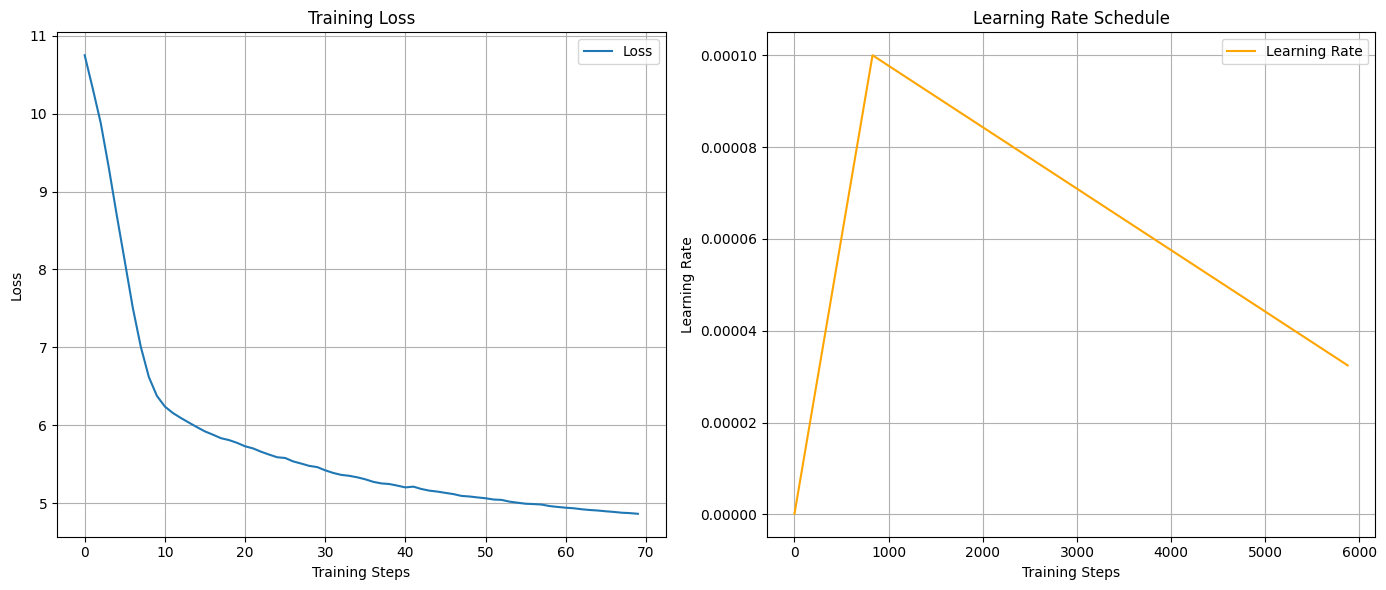

In [45]:
import matplotlib.pyplot as plt

# Визуализация графиков loss и learning rate
plt.figure(figsize=(14, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# График learning rate
plt.subplot(1, 2, 2)
plt.plot(lr_values, label='Learning Rate', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Генерация - 5 баллов
Давайте теперь попробуем посмотреть, что у нас обучилось! Для этого проверим себя на жадной генерации. KV-cache не пишем, просто:
1. Подаем input_ids, mask
2. По последнему токену жадно предсказываем следующий
3. Конактенируем этот токен к input_ids, расширяем mask
4. Повторяем num_tokens_to_generate раз

In [46]:
input_text = text[:5]
inputs = tokenizer(input_text, return_tensors="pt")

input_ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)

orig_size = input_ids.size(1)

num_tokens_to_generate = 10

# Перевод модели в режим оценки
model.eval()

with torch.no_grad():
    for i in range(num_tokens_to_generate):
        # Ваш код здесь
        # Прогоняем текущие input_ids и mask через модель
        outputs = model(input_ids, mask)  # [batch_size, seq_len, vocab_size]

        # Получаем логиты для последнего токена
        next_token_logits = outputs[:, -1, :]  # [batch_size, vocab_size]

        # Жадный выбор токена с наивысшей вероятностью
        next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)  # [batch_size, 1]

        # Добавляем предсказанный токен к input_ids
        input_ids = torch.cat([input_ids, next_token], dim=-1)  # [batch_size, seq_len +1]

        # Обновляем mask: добавляем 1 для нового токена
        mask = torch.cat([mask, torch.ones_like(next_token)], dim=-1)  # [batch_size, seq_len +1]

# Декодируем сгенерированные input_ids обратно в текст
generated_text = tokenizer.decode(input_ids[0])

print("Input text:", input_text)
print("Input text + Generated:", generated_text)

Input text: First
Input text + Generated: First the
'er the the father, and the


Если все прошло успешно, то мы увидим какой-то небольшой, но скорее всего повторяющийся текст.

Осталось отмашстабировать модель, накинуть данных и наша LLM готова!